# Python for Interactive Supernova-Cosmology Light-Curve Analysis: __PISCoLA__

## Test notebook

by Tomás Müller (University of Southampton)

___
It is recommended to run the lines one by one to get familiar with each of the functions being used (also check the docstrings!). However, I will breifly describe part of the routine below.
## Single epoch test

* The first thing to do is to set the SED template epoch/phase (respect to B-band peak) which will be used for the corrections.
* The normalization of the data helps to move all the zero-points to the same magnitude scale.
* The light curves can the be fit with Gaussian Process. A mask can be applied to the data, but the light curves need to be fit before doing so. For example, the mask can help removing data at very late time with large gaps (large gaps can decrease the quality of the GP fits!)
* It is always good to plot the different steps to make sure you understand what is happening.
* You need to choose the epochs/phases which you want to include for the light curves corrections (the more epchos, the longer it is going to take!)
* Then you can proceed to mangle the SED (template matching), one epoch at a time.
* After this, the extinction correction and K-corrections can be applied.

The example below is only for one epoch.

In [2]:
import piscola as pisco
import numpy as np

name = 03D1aw, z = 0.582, ra = 36.061634000000005, dec = -4.517158


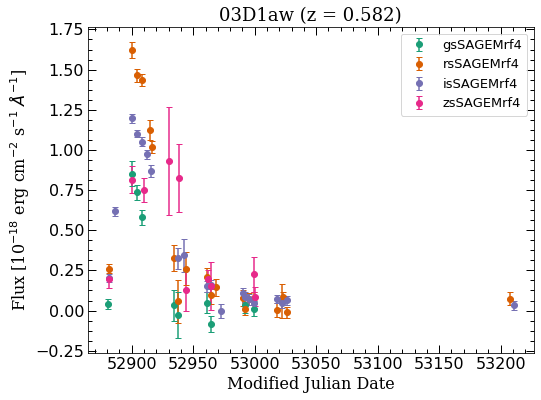

Pivot band: isSAGEMrf4
Initial B-band peak estimation: 52899.262999939


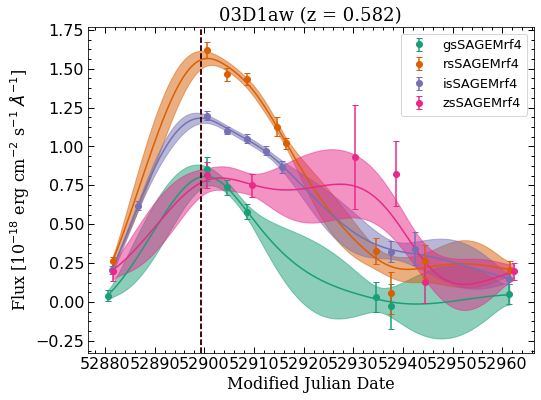

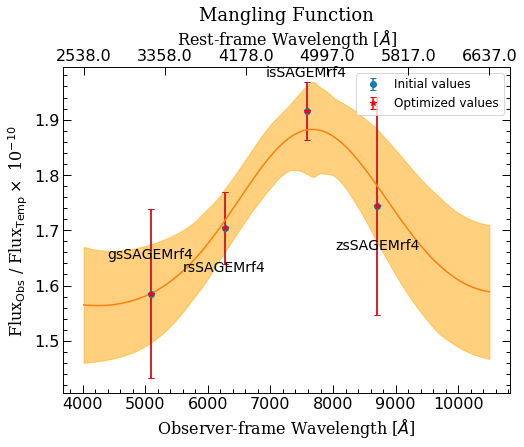

Mangling results, i.e., difference between mangled SED and "observed" magnitudes, at phase 0:
gsSAGEMrf4: 0.0007248673968973662 [mags]
rsSAGEMrf4: 0.007977929661500127 [mags]
isSAGEMrf4: -0.03284212173026191 [mags]
zsSAGEMrf4: 0.012545324273496306 [mags]


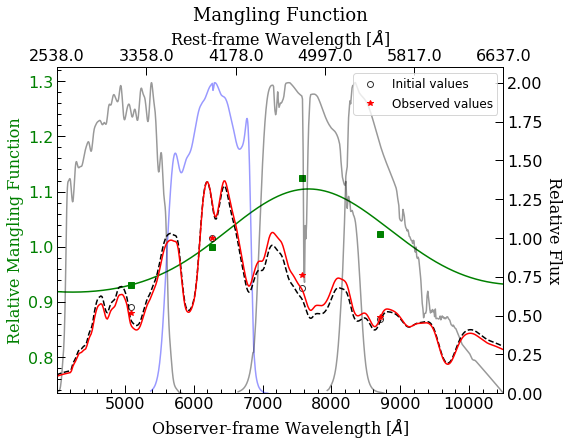

Mangling results, i.e., difference between mangled SED and "observed" magnitudes, at phase 0:
gsSAGEMrf4: 0.0007248673968973662 [mags]
rsSAGEMrf4: 0.007977929661500127 [mags]
isSAGEMrf4: -0.03284212173026191 [mags]
zsSAGEMrf4: 0.012545324273496306 [mags]


In [4]:
sn = pisco.sn_file('03D1aw')
print(sn)

########################
sn.phase=0
sn.set_sed_epoch()

sn.normalize_data()
sn.plot_data(plot_type='flux')

sn.fit_lcs(kernel='matern52')
sn.mask_data(mask_snr=False, mask_phase=True, min_phase=-20, max_phase=40)
sn.fit_lcs(kernel='matern52')

print('Pivot band:', sn.pivot_band)
print('Initial B-band peak estimation:', sn.tmax)
sn.plot_fits()

########################

phases = np.arange(-10, 21, 0.5)
sn.set_interp_data(restframe_phases=phases)

########################

sn.mangle_sed(kernel='squaredexp', method='gp')
sn.plot_mangling_function()
sn.plot_mangling_function(mangle_only=False)

sn.correct_extinction()
sn.kcorrection()

___
## Multi-epoch test

`correct_light_curve` applies most of the steps described above and loops over the given epochs. Then, `check_B_peak` checks whether the inital estimation of the B-band peak matches the final estimation (after all the corrections), and if not, repeat the correction process with the new estimation of the peak until the chosen criteria (difference between inital and final peak) is satisfied).

Once this is done, the observed parameters can be estimated.

Starting light curve correction for 03D1aw...
03D1aw iteration number 1
Starting light curve correction for 03D1aw...
03D1aw iteration number 2
Starting light curve correction for 03D1aw...


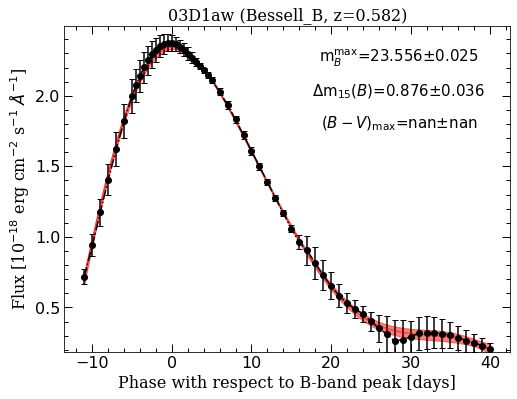

In [5]:
import piscola as pisco
import numpy as np

sn = pisco.sn_file('03D1aw')

sn.set_sed_epoch()
sn.normalize_data()

sn.fit_lcs(kernel='matern52')
sn.mask_data(mask_snr=False, mask_phase=False)
sn.fit_lcs(kernel='matern52')

phases = np.r_[np.arange(-20, -5), np.arange(-5, 5, 0.5), np.arange(5, 41)]
sn.set_interp_data(restframe_phases=phases)

sn.correct_light_curve(kernel='squaredexp')
sn.check_B_peak(kernel='squaredexp')

sn.calc_lc_parameters()
sn.display_results('Bessell_B')
try:
    sn.display_results('Bessell_V')
except:
    pass

___
## Multiple SNe in parallel

Here we create a function that does the complete routine to fit a SN.

In [ ]:
%load_ext line_profiler
from multiprocessing import Pool
import piscola as pisco
import numpy as np

def run_piscola(file):
    try:
        sn = pisco.sn_file(file)
        print(f'processing {file}...')
        
        sn.set_sed_epoch()
        sn.normalize_data()

        kernel='matern52'
        sn.fit_lcs(kernel=kernel)
        sn.mask_data(mask_snr=False, mask_phase=True, min_phase=-20, max_phase=40)
        sn.fit_lcs(kernel=kernel)

        phases = np.r_[np.arange(-20, -5), np.arange(-5, 5, 0.5), np.arange(5, 41)]
        sn.set_interp_data(restframe_phases=phases)

        kernel = 'squaredexp'
        method='gp'
        scaling = 0.86
        sn.correct_light_curve(scaling=scaling, kernel=kernel, method=method)
        sn.check_B_peak(scaling=scaling, kernel=kernel, method=method)
        sn.calc_lc_parameters()
        # sn.save(file)  # uncomment this line to save the results in dictionaries (pickle objects)
        print(f'{file} successful!')
        return sn
    except Exception as e: 
        print(f'{file} failed:', e)

Below we call the routine we defined above and use multiprocessing to paralelyse it.

In [ ]:
sne_results = Pool().map(run_piscola, (file for file in sample_files))  # sample_files is a list of SN names/files

We can also save the necessary parameters into a file to use them later on.

In [ ]:
import pandas as pd

params = pd.DataFrame({'sn':[], 'z':[], 'tmax':[], 'mb':[], 'dmb':[],'dm15':[], 'dm15err':[], 'color':[], 'dcolor':[]})

for result in sne_results: 
    
    sn = pisco.load_sn(result)
    tmax = sn.tmax
    mb = sn.lc_parameters['mb']
    dmb = sn.lc_parameters['dmb']
    dm15 = sn.lc_parameters['dm15']
    dm15err = sn.lc_parameters['dm15err']
    color = sn.lc_parameters['color']
    dcolor = sn.lc_parameters['dcolor']

    columns = ['sn', 'z', 'tmax', 'mb', 'dmb', 'dm15', 'dm15err', 'color', 'dcolor']
    values = [sn.name, sn.z, tmax, mb, dmb, dm15, dm15err, color, dcolor]

    row = pd.DataFrame(data=[values], columns=columns)
    params = params[columns].append(row)

params.to_csv('sample_name.dat', index=False)
print('ready')